In [ ]:
# Обучение проводилось в google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ЭТАП 1
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Улучшение
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/dataset/ogyeiv2/'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Количество классов: {len(train_dataset.classes)}")
print(f"Количество изображений в обучающем датасете: {len(train_dataset)}")
print(f"Количество изображений в валидационном датасете: {len(val_dataset)}")

Количество классов: 84
Количество изображений в обучающем датасете: 2352
Количество изображений в валидационном датасете: 504


In [ ]:
# ЭТАП 2
model = models.resnet18(pretrained=True)

# Улучшение: Разморозка последнего блока слоёв

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Модель готова к fine-tuning (дообучению) на устройстве: {device}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {trainable_params}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Модель готова к fine-tuning (дообучению) на устройстве: cuda
Количество обучаемых параметров: 8436820


In [ ]:
# ЭТАП 3
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], lr=0.001)

epochs = 15
best_accuracy = 0.0

print("Начинаем дообучение ")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f"Эпоха {epoch+1}/{epochs}.. "
          f"Ошибка на обучении: {train_loss_epoch:.3f}.. "
          f"Ошибка на валидации: {val_loss_epoch:.3f}.. "
          f"Точность на валидации: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'meds_classifier.pt')
        print(f"Модель сохранена с точностью: {best_accuracy:.2f}%")

print("\nОбучение завершено.")
print(f"Файл с моделью 'meds_classifier.pt' сохранен с лучшей точностью {best_accuracy:.2f}%.")

# Для экономии ресурсов можно было остановиться на эпохе 7

Начинаем дообучение (fine-tuning)...
Эпоха 1/15.. Ошибка на обучении: 3.577.. Ошибка на валидации: 2.077.. Точность на валидации: 44.84%
Модель сохранена с точностью: 44.84%
Эпоха 2/15.. Ошибка на обучении: 1.719.. Ошибка на валидации: 1.151.. Точность на валидации: 69.44%
Модель сохранена с точностью: 69.44%
Эпоха 3/15.. Ошибка на обучении: 1.043.. Ошибка на валидации: 0.713.. Точность на валидации: 81.15%
Модель сохранена с точностью: 81.15%
Эпоха 4/15.. Ошибка на обучении: 0.734.. Ошибка на валидации: 0.528.. Точность на валидации: 86.31%
Модель сохранена с точностью: 86.31%
Эпоха 5/15.. Ошибка на обучении: 0.556.. Ошибка на валидации: 0.415.. Точность на валидации: 90.28%
Модель сохранена с точностью: 90.28%
Эпоха 6/15.. Ошибка на обучении: 0.429.. Ошибка на валидации: 0.321.. Точность на валидации: 91.27%
Модель сохранена с точностью: 91.27%
Эпоха 7/15.. Ошибка на обучении: 0.338.. Ошибка на валидации: 0.241.. Точность на валидации: 93.65%
Модель сохранена с точностью: 93.65%
Эпох

Итоговая общая точность (Accuracy): 96.23%

Детальный отчёт по классам:
                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       0.86      1.00      0.92         6
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       1.00      1.00      1.00         6
             ambroxol_egis_30_mg       1.00      0.50      0.67         6
                  apranax_550_mg       1.00      1.00      1.00         6
            aspirin_ultra_500_mg       1.00      1.00      1.00         6
                    atoris_20_mg       1.00      1.00      1.00         6
         atorvastatin_teva_20_mg       0.75      1.00      0.86         6
                   betaloc_50_mg       

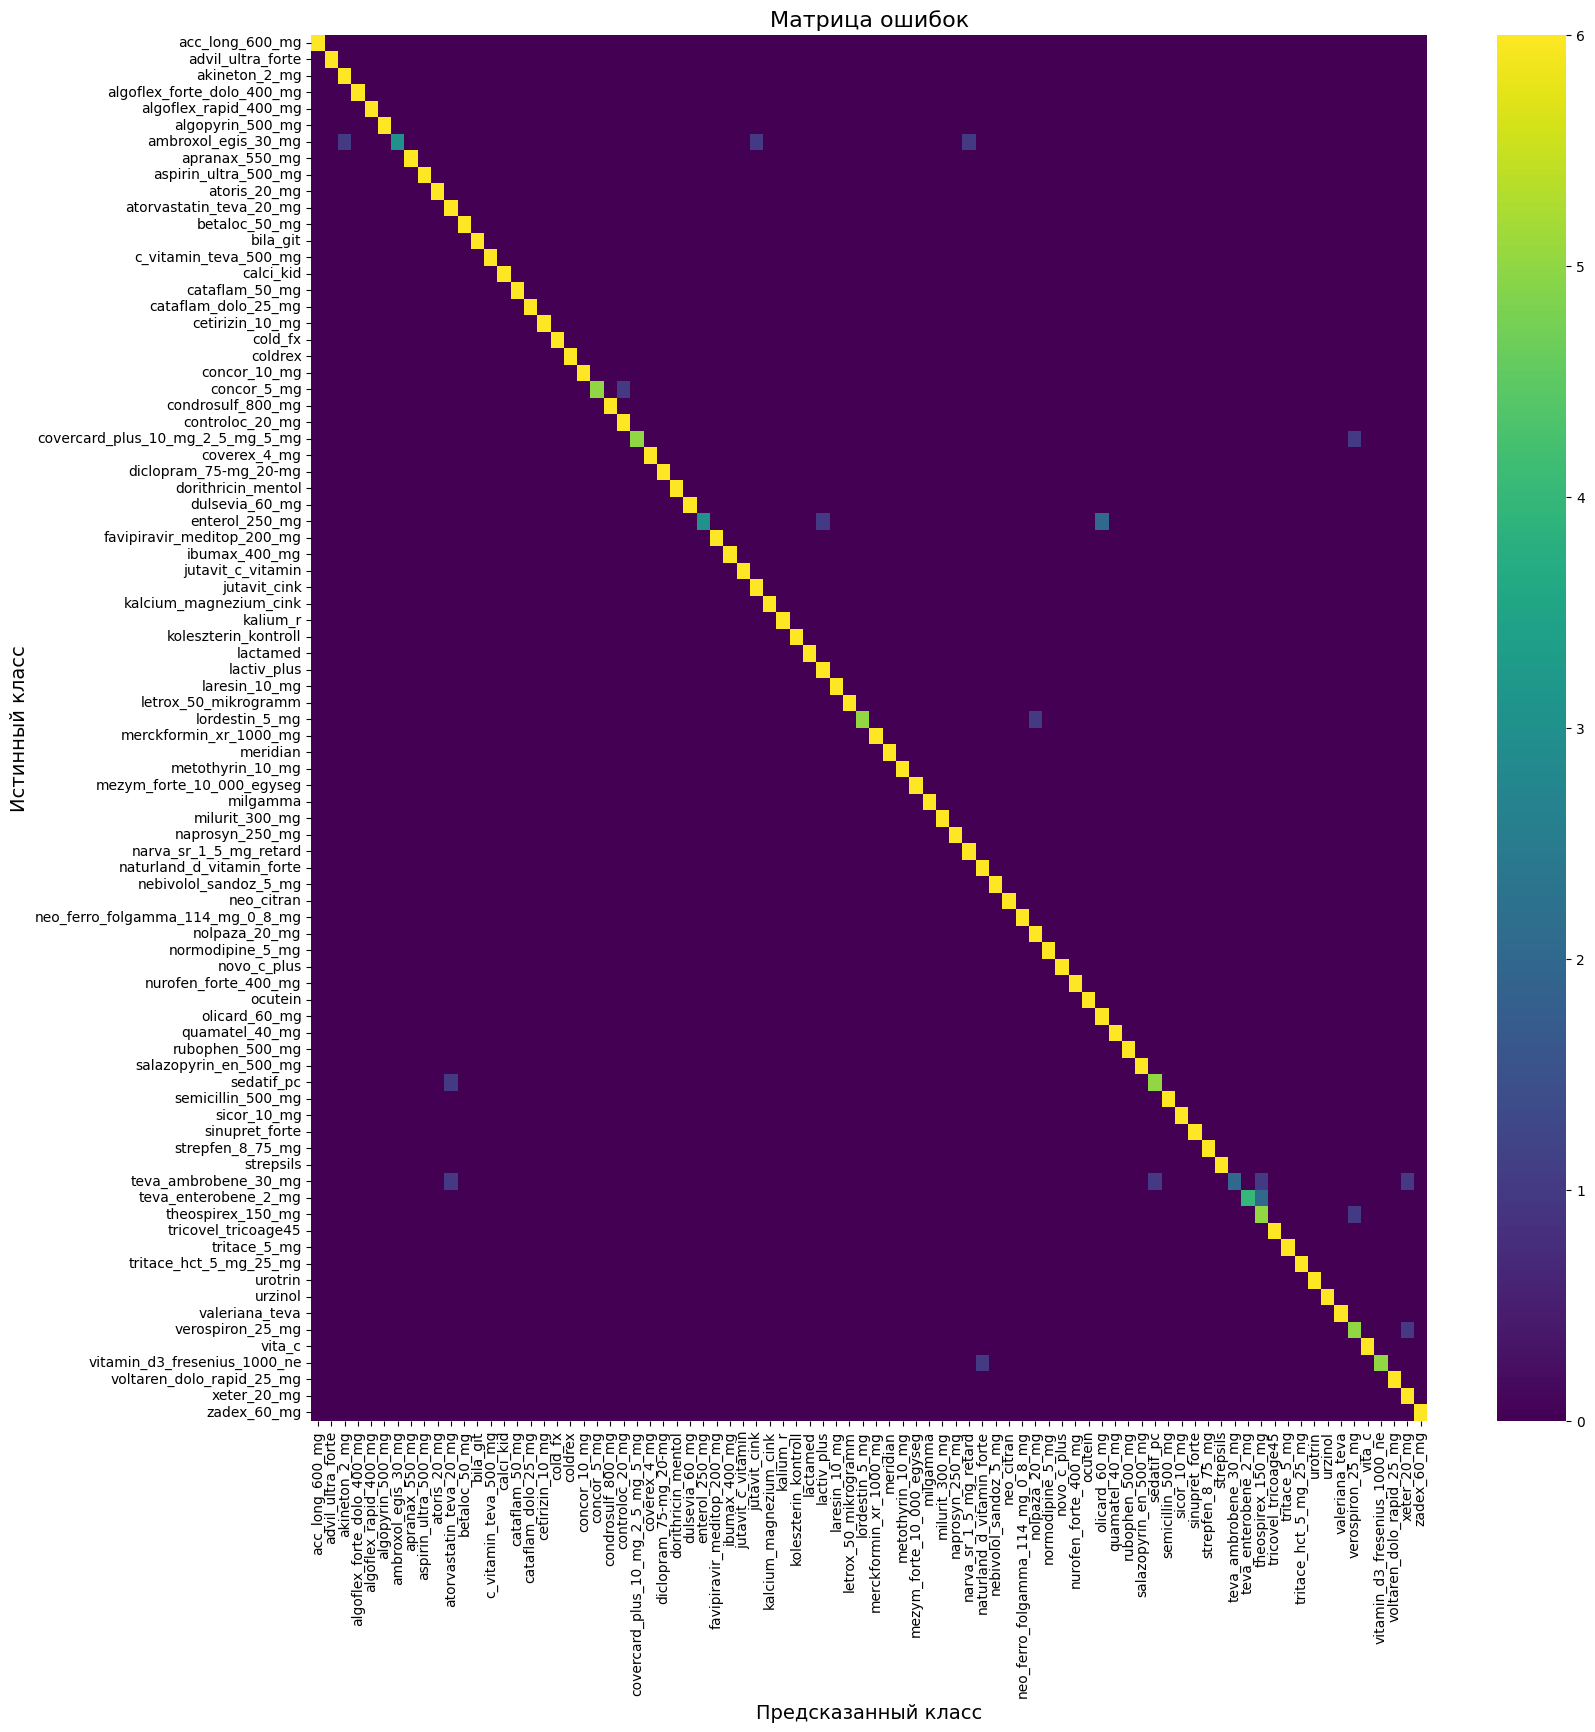

In [ ]:
# ЭТАП 4
model.load_state_dict(torch.load('meds_classifier.pt'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
print("="*30)
print(f"Итоговая общая точность (Accuracy): {accuracy*100:.2f}%")
print("="*30)

class_names = val_dataset.classes
print("\nДетальный отчёт по классам:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\n--- Анализ результатов ---")
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
class_f1_scores = {name: metrics['f1-score'] for name, metrics in report.items() if isinstance(metrics, dict)}
sorted_classes = sorted(class_f1_scores.items(), key=lambda item: item[1])
print("\nНа каких 5 классах модель ошибается чаще всего (по F1-score):")
for class_name, score in sorted_classes[:5]:
    print(f"- {class_name}: F1-score = {score:.2f}")
print("\n...")



# Ответы

### 1. На каких 5 классах модель ошибается чаще всего?


teva_ambrobene_30_mg: F1-score = 0.50

ambroxol_egis_30_mg: F1-score = 0.67

enterol_250_mg: F1-score = 0.67

theospirex_150_mg: F1-score = 0.71

verospiron_25_mg: F1-score = 0.77

### 2. Почему модель может ошибаться на этих классах?

Визуальная схожесть. Teva_ambrobene_30_mg и ambroxol_egis_30_mg - это препараты с одним и тем же действующим веществом

### 3. На каких классах модель не совершает ошибок?
Модель показала идеальный результат на огромном количестве классов. Например:

acc_long_600_mg

advil_ultra_forte

algopyrin_500_mg


и многие другие.

### 4. Почему эти классы модель распознаёт безошибочно?

Уникальные визуальные черты, хорошие изображения препаратов

### 5. Как можно улучшить точность классификатора?
Использовать более сложные модели

### 6. Как ещё можно проанализировать результаты и ошибки модели?
Написать скрипт, который будет выводить таблетки, на которых модель ошиблась. Изучить причины.